In [ ]:
from google.colab import drive

!pip install rdkit-pypi
!pip install py3Dmol
drive.mount('/content/drive')

     |████████████████████████████████| 22.5 MB 46.0 MB/s 
Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

## About dataset
Dataset contains drug-like compounds which can be potential inhibitors of GP120 - CD4 interaction. Compounds are stored in SMILES format. Also data contains binding free energy for molecules.

In [ ]:
DATASETS_FOLDER = '/content/drive/MyDrive/datasets/gp120'

smifile = f'{DATASETS_FOLDER}/smiles_dataset.smi'
data = pd.read_csv(smifile, delimiter='\t', names=["smiles", "energy"])
data.head()

,smiles,energy
0,CC(C)CC(C)(C)C,0.293701
1,CC(N)CC(C)(C)C,0.383321
2,CC(O)CC(C)(C)C,0.343287
3,CC(F)CC(C)(C)C,0.657678
4,CC(C)(C)CC(F)F,0.384666


### Train and test sets creation
First of all, we need to shuffle our data and divide it into train and test datasets.

In [ ]:
data = data.sample(frac=1, random_state=42)

smiles_train, smiles_test = train_test_split(data["smiles"], shuffle=False)
energy_train, energy_test = train_test_split(data["energy"], shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)

(50029,)
(16677,)


### SMILES alphabet
The autoencoder input layer receives a tensor of numbers and works with it. So we need to vectorize SMILES representation of molecules. This can be done with one-hot encoding. To create binary vector which represents SMILES, we need to count number of distinct symbols in compound formulas and the max length of word in dataset first. We also add "!" and "E" symbols to alphabet as start and end symbols.

In [ ]:
charset = set("".join(list(data.smiles)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))
int_to_char = dict((i, c) for i, c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'!', '=', 'o', 'F', '1', ')', '2', 'O', '4', 'N', 'n', 'E', '-', 'c', '+', '[', '3', '#', ']', '(', 'H', 'C'}
22 28


### SMILES vectorization
Now we can begin vectorization procedure.

In [ ]:
def vectorize(smiles):
    one_hot = np.zeros((smiles.shape[0], embed, len(charset)), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i, 0, char_to_int["!"]] = 1
        for j, c in enumerate(smile):
            one_hot[i, j + 1, char_to_int[c]] = 1
        one_hot[i, len(smile) + 1:, char_to_int["E"]] = 1
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

COc1nncn1O


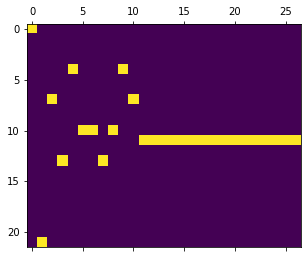

In [ ]:
X_train, Y_train = vectorize(smiles_train.values)
X_test, Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)

In [ ]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

unroll = False
encoder_inputs = Input(shape=input_shape, name='Smiles_input_1')
encoder = LSTM(lstm_dim, return_state=True,
               unroll=unroll, name='Encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1, name='States_concat')([state_h, state_c])
neck = Dense(latent_dim, activation="relu", name='Encoder_neck')
neck_outputs = neck(states)

free_energy_inputs = Input(shape=(1,), name='Energy_input')
concatenate = Concatenate(axis=-1, name='Energy_concat')
energy_concat = concatenate([neck_outputs, free_energy_inputs])

decode_h = Dense(lstm_dim, name='State_h_decoder', activation="relu")
decode_c = Dense(lstm_dim, name='State_c_decoder', activation="relu")
state_h_decoded = decode_h(energy_concat)
state_c_decoded = decode_c(energy_concat)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape, name='Smiles_input_2')
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    name='Decoder_lstm'
                    )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax', name='Decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs, free_energy_inputs], decoder_outputs, name='Lstm_autoencoder')
plot_model(model, to_file='model.png', show_layer_activations=True)
print(model.summary())

Model: "Lstm_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Smiles_input_1 (InputLayer)    [(None, 27, 22)]     0           []                               
                                                                                                  
 Encoder_lstm (LSTM)            [(None, 64),         22272       ['Smiles_input_1[0][0]']         
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 States_concat (Concatenate)    (None, 128)          0           ['Encoder_lstm[0][1]',           
                                                                  'Encoder_lstm[0][

In [ ]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [ ]:
model.fit([X_train, X_train, energy_train], Y_train,
                    epochs=160,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=([X_test, X_test, energy_test], Y_test))

Epoch 1/160
196/196 [==============================] - 10s 29ms/step - loss: 0.9066 - val_loss: 0.6631 - lr: 0.0050
Epoch 2/160
196/196 [==============================] - 5s 24ms/step - loss: 0.6091 - val_loss: 0.5690 - lr: 0.0050
Epoch 3/160
196/196 [==============================] - 5s 24ms/step - loss: 0.5541 - val_loss: 0.5372 - lr: 0.0050
Epoch 4/160
196/196 [==============================] - 5s 24ms/step - loss: 0.5161 - val_loss: 0.4864 - lr: 0.0050
Epoch 5/160
196/196 [==============================] - 5s 24ms/step - loss: 0.4676 - val_loss: 0.4655 - lr: 0.0050
Epoch 6/160
196/196 [==============================] - 5s 24ms/step - loss: 0.4311 - val_loss: 0.4129 - lr: 0.0050
Epoch 7/160
196/196 [==============================] - 5s 24ms/step - loss: 0.3987 - val_loss: 0.3821 - lr: 0.0050
Epoch 8/160
196/196 [==============================] - 5s 24ms/step - loss: 0.3784 - val_loss: 0.3511 - lr: 0.0050
Epoch 9/160
196/196 [==============================] - 5s 24ms/step - loss: 0.3

In [ ]:
import pickle
with open("Blog_history.pickle", "wb") as f:
    pickle.dump(h.history, f)

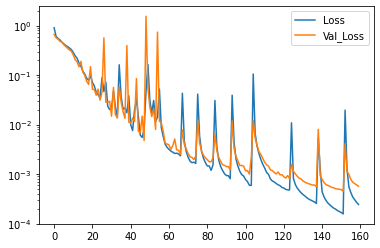

In [ ]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [ ]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

2022-04-05 17:55:18.557 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [ ]:
latent_input = Input(shape=(latent_dim,))
energy_input = Input(shape=(1,))

energy_concat_2 = concatenate([latent_input, energy_input])

state_h_decoded_2 = decode_h(energy_concat_2)
state_c_decoded_2 = decode_c(energy_concat_2)

latent_to_states_model = Model([latent_input, energy_input], 
                               [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")
latent_to_states_model.summary()

2022-04-05 17:55:20.947 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Energy_concat (Concatenate)    (None, 65)           0           ['input_38[0][0]',               
                                                                  'input_39[0][0]']               
                                                                                                  
 State_h_decoder (Dense)        (None, 64)           4224        ['Energy_concat[1][0]']   

In [ ]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [ ]:
sample_model.layers[1].set_weights(model.layers[-2].get_weights())
sample_model.layers[2].set_weights(model.layers[-1].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

sample_model.summary()

2022-04-05 17:55:26.024 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(1, 1, 22)]              0         
                                                                 
 lstm_26 (LSTM)              (1, 1, 64)                22272     
                                                                 
 dense_40 (Dense)            (1, 1, 22)                1430      
                                                                 
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_latent = smiles_to_latent_model.predict(X_test)
free_energy_value = 0.5
free_energy = np.array([free_energy_value])

In [ ]:
def latent_to_smiles(latent, free_energy):
    states = latent_to_states_model.predict([latent, free_energy])
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    # добавление стартового символа
    startidx = char_to_int["!"]
    samplevec = np.zeros((1, 1, len(charset)))
    samplevec[0,0,startidx] = 1
    smiles = ""
    # предсказание следующего символа
    for i in range(embed):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1, 1, len(charset)))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [ ]:
smiles = latent_to_smiles(x_latent[10:11], free_energy)
print(smiles)
print(smiles_test.iloc[10])

NN1C(=N)CCC1=N
NN1C(=N)CCC1=N


FC1CCO(CF)O1C
FC1CC(O1F)C#N
FC1C#NCC(F)=O1


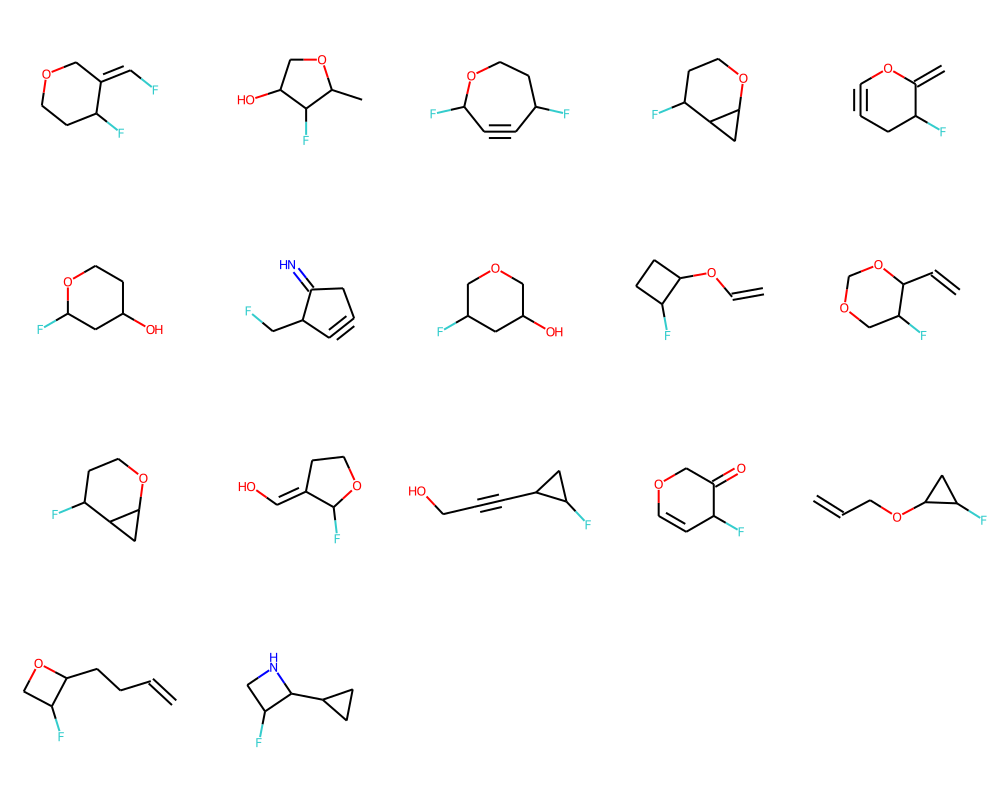

In [ ]:
# генерация соединения из latent space с добавлением шума
latent = x_latent[0:1]
scale = 0.30
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1]))
    smiles = latent_to_smiles(latent_r, free_energy)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)

Draw.MolsToGridImage(mols, molsPerRow=5)

In [ ]:
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem

def makeblock(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mblock = Chem.MolToMolBlock(mol)
    return mblock

def render_mol(xyz):
    xyzview = py3Dmol.view()
    xyzview.addModel(xyz,'mol')
    xyzview.setStyle({'stick':{}})
    xyzview.setBackgroundColor('white')
    xyzview.zoomTo()
    xyzview.show()


compound_smiles = smiles_train.iloc[0]
blk = makeblock(compound_smiles)
print(compound_smiles)
render_mol(blk)

COc1nncn1O


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

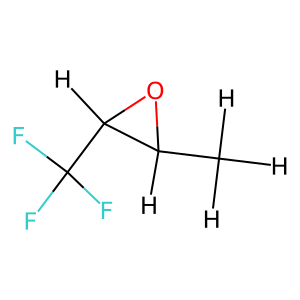

In [ ]:
mol = AllChem.MolFromSmiles(compound_smiles)
mol = Chem.AddHs(mol)
Draw.MolToImage(mol)